In [1]:
# Imports

#General
import numpy as np
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import classification_report


# Deep Learning
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import plot_model


# Deep Learning
import tensorflow as tf
from tensorflow.python.client import device_lib 
from keras.backend.tensorflow_backend import set_session
from tensorflow.python.client import device_lib
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
from keras.models import load_model

# Audio
import librosa.display, librosa

Using TensorFlow backend.
/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rutherford/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rutherford/.local/lib/python3.6/site-packages/t

# Get filenames

In [30]:
# Get files in data path
path='BirdSound/'
# Get Audio Files
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 450 audio files in BirdSound/


# Prepare labels from filenames

In [31]:
# Get Labels
labels =[]
classes=['Avocet','Coot','Crake','Crane', 'Dove','Gallinule', 
         'Grebe','Grouse','Lapwing','Nightjar','Oystercatcher','Pheasant',
         'Pigeon','Plover','Quail','Rail','Sandpiper','Stilt','Swift','Turaco']

color_dict={'Avocet':'blue','Coot':'magenta','Crake':'magenta','Crane':'magenta', 'Dove':'magenta',
         'Gallinule':'magenta','Grebe':'magenta','Grouse':'magenta','Lapwing':'magenta','Nightjar':'magenta',
         'Oystercatcher':'magenta','Pheasant':'magenta','Pigeon':'magenta','Plover':'magenta',
         'Quail':'magenta','Rail':'magenta','Sandpiper':'magenta','Stilt':'magenta','Swift':'magenta',
         'Turaco':'magenta'}

color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

# Encoded Labels

In [32]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

20 classes: Avocet, Coot, Crake, Crane, Dove, Gallinule, Grebe, Grouse, Lapwing, Nightjar, Oystercatcher, Pheasant, Pigeon, Plover, Quail, Rail, Sandpiper, Stilt, Swift, Turaco


# Parameters

In [33]:
# Signal Processing Parameters
fs = 22050        # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frame
n_mels = 128       # Number of Mel bands        
# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing

# Feature Extraction

In [34]:
#y, sr = librosa.load(librosa.util.example_audio_file())
#librosa.feature.melspectrogram(y=y, sr=sr)

In [35]:
def get_features(y, sr=fs):
    melspectrogram = librosa.feature.melspectrogram(y, sr=fs)
    feature_vector = np.mean(melspectrogram,1)
    return feature_vector

# Load audio files, calculate features and create feature vectors

In [36]:
# Load audio files, calculate features and create feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))

get 1 of 450 = BirdSound/Gallinule/XC131319 - Common Gallinule - Gallinula galeata.wav
get 2 of 450 = BirdSound/Gallinule/XC465599 - Common Gallinule - Gallinula galeata cachinnans.wav
get 3 of 450 = BirdSound/Gallinule/XC452961 - Common Gallinule - Gallinula galeata.wav
get 4 of 450 = BirdSound/Gallinule/XC45353 - Spot-flanked Gallinule - Porphyriops melanops crassirostris.wav
get 5 of 450 = BirdSound/Gallinule/XC91834 - Spot-flanked Gallinule - Porphyriops melanops.wav
get 6 of 450 = BirdSound/Gallinule/XC414334 - Common Gallinule - Gallinula galeata.wav
get 7 of 450 = BirdSound/Gallinule/XC368531 - Common Gallinule - Gallinula galeata.wav
get 8 of 450 = BirdSound/Gallinule/XC37123 - Purple Gallinule - Porphyrio martinica.wav
get 9 of 450 = BirdSound/Gallinule/XC7979 - Common Gallinule - Gallinula galeata.wav
get 10 of 450 = BirdSound/Gallinule/XC246282 - Common Gallinule - Gallinula galeata.wav
get 11 of 450 = BirdSound/Gallinule/XC384693 - Common Gallinule - Gallinula galeata.wav
g

get 95 of 450 = BirdSound/Crane/XC216976 - Common Crane - Grus grus.wav
get 96 of 450 = BirdSound/Crake/XC364028 - Rufous-faced Crake - Laterallus xenopterus.wav
get 97 of 450 = BirdSound/Crake/XC15483 - Rufous-faced Crake - Laterallus xenopterus.wav
get 98 of 450 = BirdSound/Crake/XC270595 - Chestnut-headed Crake - Anurolimnas castaneiceps.wav
get 99 of 450 = BirdSound/Crake/XC237988 - Chestnut-headed Crake - Anurolimnas castaneiceps castaneiceps.wav
get 100 of 450 = BirdSound/Crake/XC13469 - Black-banded Crake - Laterallus fasciatus~1.wav
get 101 of 450 = BirdSound/Crake/XC224864 - Rusty-flanked Crake - Laterallus levraudi.wav
get 102 of 450 = BirdSound/Crake/XC69265 - Spotless Crake - Porzana tabuensis.wav
get 103 of 450 = BirdSound/Crake/XC288426 - Grey-breasted Crake - Laterallus exilis.wav
get 104 of 450 = BirdSound/Crake/XC218852 - Russet-crowned Crake - Laterallus viridis.wav
get 105 of 450 = BirdSound/Crake/XC13469 - Black-banded Crake - Laterallus fasciatus.wav
get 106 of 450

get 187 of 450 = BirdSound/Dove/XC17077 - Ruddy Ground Dove - Columbina talpacoti.wav
get 188 of 450 = BirdSound/Dove/XC74980 - Common Ground Dove - Columbina passerina.wav
get 189 of 450 = BirdSound/Dove/XC300695 - Ring-necked Dove - Streptopelia capicola somalica.wav
get 190 of 450 = BirdSound/Dove/XC209306 - Blue Ground Dove - Claravis pretiosa.wav
get 191 of 450 = BirdSound/Coot/XC14381 - American Coot - Fulica americana~1.wav
get 192 of 450 = BirdSound/Coot/XC287245 - Andean Coot - Fulica ardesiaca.wav
get 193 of 450 = BirdSound/Coot/XC139909 - American Coot - Fulica americana.wav
get 194 of 450 = BirdSound/Coot/XC48557 - Red-fronted Coot - Fulica rufifrons.wav
get 195 of 450 = BirdSound/Coot/XC175423 - Eurasian Coot - Fulica atra.wav
get 196 of 450 = BirdSound/Coot/XC57425 - American Coot - Fulica americana.wav
get 197 of 450 = BirdSound/Coot/XC160661 - American Coot - Fulica americana.wav
get 198 of 450 = BirdSound/Coot/XC37846 - American Coot - Fulica americana.wav
get 199 of 4

get 282 of 450 = BirdSound/Plover/XC429053 - Purple-crowned Plovercrest - Stephanoxis loddigesii.wav
get 283 of 450 = BirdSound/Plover/XC450072 - Magellanic Plover - Pluvianellus socialis.wav
get 284 of 450 = BirdSound/Plover/XC140325 - Little Ringed Plover - Charadrius dubius papuanus.wav
get 285 of 450 = BirdSound/Plover/XC59911 - Rufous-chested Plover - Charadrius modestus.wav
get 286 of 450 = BirdSound/Plover/XC371003 - Kentish Plover - Charadrius alexandrinus.wav
get 287 of 450 = BirdSound/Plover/XC309206 - Little Ringed Plover - Charadrius dubius curonicus.wav
get 288 of 450 = BirdSound/Plover/XC356536 - Common Ringed Plover - Charadrius hiaticula.wav
get 289 of 450 = BirdSound/Plover/XC345511 - European Golden Plover - Pluvialis apricaria.wav
get 290 of 450 = BirdSound/Plover/XC51732 - Collared Plover - Charadrius collaris.wav
get 291 of 450 = BirdSound/Plover/XC339475 - Common Ringed Plover - Charadrius hiaticula.wav
get 292 of 450 = BirdSound/Plover/XC378002 - Common Ringed Pl

get 369 of 450 = BirdSound/Oystercatcher/XC329469 - African Oystercatcher - Haematopus moquini.wav
get 370 of 450 = BirdSound/Oystercatcher/XC144971 - Eurasian Oystercatcher - Haematopus ostralegus.wav
get 371 of 450 = BirdSound/Pigeon/XC715 - Ruddy Pigeon - Patagioenas subvinacea.wav
get 372 of 450 = BirdSound/Pigeon/XC368234 - Dusky Pigeon - Patagioenas goodsoni.wav
get 373 of 450 = BirdSound/Pigeon/XC221376 - Short-billed Pigeon - Patagioenas nigrirostris.wav
get 374 of 450 = BirdSound/Pigeon/XC205976 - Picazuro Pigeon - Patagioenas picazuro.wav
get 375 of 450 = BirdSound/Pigeon/XC94615 - Common Wood Pigeon - Columba palumbus.wav
get 376 of 450 = BirdSound/Pigeon/XC246531 - White-bellied Green Pigeon - Treron sieboldii.wav
get 377 of 450 = BirdSound/Pigeon/XC39584 - Ruddy Pigeon - Patagioenas subvinacea.wav
get 378 of 450 = BirdSound/Pigeon/XC166060 - Orange-breasted Green Pigeon - Treron bicinctus.wav
get 379 of 450 = BirdSound/Pigeon/XC271973 - Plumbeous Pigeon - Patagioenas plumb

# Standardization: Zero-Mean and Unit-Variance

In [37]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (450, 128)


# Train and Test Sets

In [38]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [39]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (337, 128)
test_set shape: (113, 128)
train_classes shape: (337,)
test_classes shape: (113,)


# Keras

In [40]:
# DNN
# Use Keras Backend Type
train_set_d=train_set.astype(K.floatx())
test_set_d=test_set.astype(K.floatx())

# One Hot Encoding

In [41]:
# One Hot encode
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
integer_encoded_train_classes =  train_classes.reshape(len( train_classes), 1)
onehot_encoded_train_classes = onehot_encoder.fit_transform(integer_encoded_train_classes,1)
integer_encoded_test_classes =  test_classes.reshape(len( test_classes),1)
onehot_encoded_test_classes = onehot_encoder.fit_transform(integer_encoded_test_classes,1)

In [42]:
# Check Set Shapes
print("train_set shape:",train_set_d.shape)
print("test_set shape:",test_set_d.shape)
print("train_classes shape:",onehot_encoded_train_classes.shape)
print("test_classes shape:",onehot_encoded_test_classes.shape)

train_set shape: (337, 128)
test_set shape: (113, 128)
train_classes shape: (337, 20)
test_classes shape: (113, 20)


In [43]:
# Reshape Sets for Keras
train_set_d=train_set.reshape(train_set_d.shape[0],1,train_set_d.shape[1])
test_set_d=test_set.reshape(test_set_d.shape[0],1,test_set_d.shape[1])
train_classes_d_hot=onehot_encoded_train_classes.reshape(onehot_encoded_train_classes.shape[0],1,
                                                         onehot_encoded_train_classes.shape[1])
test_classes_d_hot=onehot_encoded_test_classes.reshape(onehot_encoded_test_classes.shape[0],1,
                                                       onehot_encoded_test_classes.shape[1])

In [44]:
# Check Set Shapes
print("train_set shape:",train_set_d.shape)
print("test_set shape:",train_set_d.shape)
print("train_classes shape:",train_classes_d_hot.shape)
print("test_classes shape:",test_classes_d_hot.shape)

train_set shape: (337, 1, 128)
test_set shape: (337, 1, 128)
train_classes shape: (337, 1, 20)
test_classes shape: (113, 1, 20)


# Create a Model

In [45]:
# Creat Simple Model
model_input = Input(shape=(1,train_set.shape[1]))
fc1 = Dense(70, activation="relu")(model_input)
fc2 = Dense(60, activation="relu")(fc1)
fc3 = Dense(50, activation="relu")(fc2)
fc4 = Dense(40, activation="relu")(fc3)
fc5 = Dense(30, activation="relu")(fc4)
fc6 = Dense(20, activation="relu")(fc5)
n=onehot_encoded_train_classes.shape[1]
out = Dense(n, activation="softmax")(fc4)
model_d = Model(inputs=[model_input], outputs=[out])
model_d.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 128)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 70)             9030      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 60)             4260      
_________________________________________________________________
dense_3 (Dense)              (None, 1, 50)             3050      
_________________________________________________________________
dense_4 (Dense)              (None, 1, 40)             2040      
_________________________________________________________________
dense_7 (Dense)              (None, 1, 20)             820       
Total params: 19,200
Trainable params: 19,200
Non-trainable params: 0
_______________________________________________________

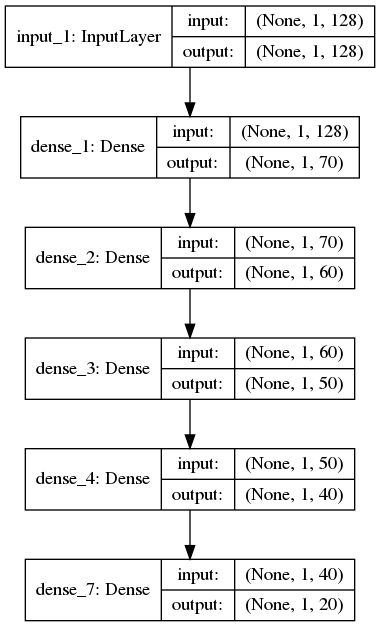

In [46]:
import pydotplus
import keras.utils
keras.utils.vis_utils.pydot = pydotplus
keras.utils.plot_model(model_d, to_file='model.png', show_shapes=True)

# Compile a Model

In [47]:
# Compile Model
model_d.compile(loss      = 'categorical_crossentropy',
              optimizer = SGD(lr=0.05),
              metrics   =['accuracy'])

# Train a Model

In [48]:
# Deep Learning Parameters
batch_size = 5 # Number of samples per gradient update.
epochs = 200    # An epoch is an iteration over the entire x and y data provided.

# Train Model
hist = model_d.fit(train_set_d, train_classes_d_hot, verbose=1, 
                    batch_size=batch_size, epochs=epochs, validation_data=(test_set_d,test_classes_d_hot))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 337 samples, validate on 113 samples
Epoch 1/200
337/337 [==============================] - 1s 3ms/step - loss: 2.9801 - accuracy: 0.0593 - val_loss: 2.8898 - val_accuracy: 0.1062
Epoch 2/200
337/337 [==============================] - 0s 584us/step - loss: 2.7572 - accuracy: 0.1454 - val_loss: 2.7904 - val_accuracy: 0.1770
Epoch 3/200
337/337 [==============================] - 0s 637us/step - loss: 2.5545 - accuracy: 0.2255 - val_loss: 2.9791 - val_accuracy: 0.0885
Epoch 4/200
337/337 [==============================] - 0s 578us/step - loss: 2.4310 - accuracy: 0.2522 - val_loss: 2.8837 - val_accuracy: 0.1947
Epoch 5/200
337/337 [==============================] - 0s 590us/step - loss: 2.3281 - accuracy: 0.2908 - val_loss: 2.8744 - val_accuracy: 0.1770
Epoch 6/200
337/337 [==============================] - 0s 547us/step - loss: 2.1549 - accuracy: 0.3234 - val_loss: 2.8588 - val_accuracy

337/337 [==============================] - 0s 499us/step - loss: 1.0297 - accuracy: 0.7240 - val_loss: 5.2685 - val_accuracy: 0.1858
Epoch 54/200
337/337 [==============================] - 0s 480us/step - loss: 0.8167 - accuracy: 0.7685 - val_loss: 5.2955 - val_accuracy: 0.2389
Epoch 55/200
337/337 [==============================] - 0s 502us/step - loss: 0.5425 - accuracy: 0.8516 - val_loss: 5.7750 - val_accuracy: 0.2478
Epoch 56/200
337/337 [==============================] - 0s 495us/step - loss: 0.7472 - accuracy: 0.8131 - val_loss: 6.3075 - val_accuracy: 0.2389
Epoch 57/200
337/337 [==============================] - 0s 469us/step - loss: 0.5502 - accuracy: 0.8457 - val_loss: 5.8904 - val_accuracy: 0.2301
Epoch 58/200
337/337 [==============================] - 0s 484us/step - loss: 0.4334 - accuracy: 0.8694 - val_loss: 6.3032 - val_accuracy: 0.2566
Epoch 59/200
337/337 [==============================] - 0s 495us/step - loss: 0.4797 - accuracy: 0.8724 - val_loss: 6.1851 - val_accuracy

337/337 [==============================] - 0s 499us/step - loss: 0.5284 - accuracy: 0.8813 - val_loss: 6.8796 - val_accuracy: 0.2212
Epoch 110/200
337/337 [==============================] - 0s 540us/step - loss: 0.4939 - accuracy: 0.9021 - val_loss: 6.8199 - val_accuracy: 0.2212
Epoch 111/200
337/337 [==============================] - 0s 487us/step - loss: 0.4807 - accuracy: 0.8991 - val_loss: 7.1667 - val_accuracy: 0.1947
Epoch 112/200
337/337 [==============================] - 0s 532us/step - loss: 0.5440 - accuracy: 0.8872 - val_loss: 6.8087 - val_accuracy: 0.2212
Epoch 113/200
337/337 [==============================] - 0s 505us/step - loss: 0.4288 - accuracy: 0.9110 - val_loss: 7.8404 - val_accuracy: 0.1947
Epoch 114/200
337/337 [==============================] - 0s 508us/step - loss: 0.4887 - accuracy: 0.8932 - val_loss: 7.3588 - val_accuracy: 0.2478
Epoch 115/200
337/337 [==============================] - 0s 511us/step - loss: 0.9740 - accuracy: 0.7923 - val_loss: 6.5144 - val_ac

Epoch 165/200
337/337 [==============================] - 0s 663us/step - loss: 1.5845 - accuracy: 0.5312 - val_loss: 4.9923 - val_accuracy: 0.1858
Epoch 166/200
337/337 [==============================] - 0s 686us/step - loss: 1.8558 - accuracy: 0.5549 - val_loss: 6.0768 - val_accuracy: 0.1858
Epoch 167/200
337/337 [==============================] - 0s 529us/step - loss: 2.2525 - accuracy: 0.4481 - val_loss: 4.3377 - val_accuracy: 0.1593
Epoch 168/200
337/337 [==============================] - 0s 668us/step - loss: 1.8703 - accuracy: 0.4451 - val_loss: 4.9690 - val_accuracy: 0.1770
Epoch 169/200
337/337 [==============================] - 0s 491us/step - loss: 2.1472 - accuracy: 0.3858 - val_loss: 4.1682 - val_accuracy: 0.1327
Epoch 170/200
337/337 [==============================] - 0s 705us/step - loss: 1.9160 - accuracy: 0.4214 - val_loss: 4.4705 - val_accuracy: 0.1504
Epoch 171/200
337/337 [==============================] - 0s 495us/step - loss: 1.8687 - accuracy: 0.4303 - val_loss: 4

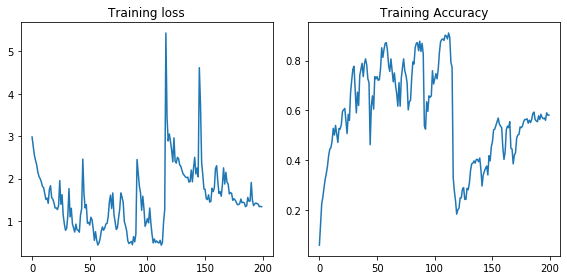

In [49]:
# Plot Training Loss and Training Accuracy
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.title("Training loss")
plt.plot(range(epochs),hist.history["loss"])

plt.subplot(1, 2, 2)
plt.title("Training Accuracy")
plt.plot(range(epochs),hist.history["accuracy"])

plt.tight_layout()

# Make Predictions

In [50]:
# Predict
predictions = model_d.predict(test_set_d)
predictions_round=predictions.round().astype('int')
predictions_int=np.argmax(predictions_round,axis=2)
predictions_labels=labelencoder.inverse_transform(np.ravel(predictions_int))

# Evaluation

In [51]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_num[test_index], predictions_int,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_num[test_index], predictions_int,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_num[test_index], predictions_int, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_num[test_index], predictions_int,normalize=True), accuracy_score(classes_num[test_index], predictions_int,normalize=False) )
print("Number of samples:",classes_num[test_index].shape[0])

print(classification_report(classes_num[test_index], predictions_int))

Recall:  [1.         0.5        0.         0.5        0.14285714 0.
 0.         0.         0.         0.16666667 0.2        0.2
 0.         0.         0.         0.         0.2        0.
 0.2        0.        ]
Precision:  [0.12       0.23076923 0.         0.6        0.5        0.
 0.         0.         0.         0.2        1.         0.14285714
 0.         0.         0.         0.         0.5        0.
 0.14285714 0.        ]
F1-Score:  [0.21428571 0.31578947 0.         0.54545455 0.22222222 0.
 0.         0.         0.         0.18181818 0.33333333 0.16666667
 0.         0.         0.         0.         0.28571429 0.
 0.16666667 0.        ]
Accuracy: 0.16  , 18
Number of samples: 113
              precision    recall  f1-score   support

           0       0.12      1.00      0.21         6
           1       0.23      0.50      0.32         6
           2       0.00      0.00      0.00         7
           3       0.60      0.50      0.55         6
           4       0.50      0.14

/home/rutherford/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rutherford/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_num[test_index], predictions_int)
np.set_printoptions(precision=2)

In [53]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

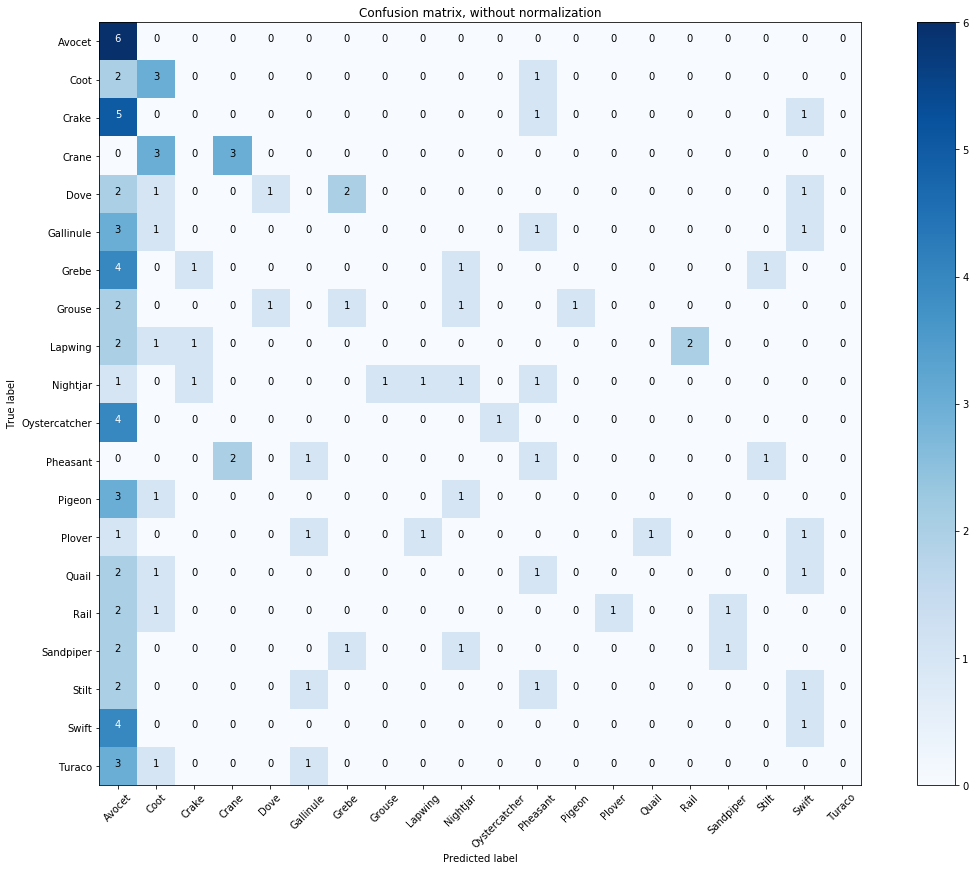

In [54]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [55]:
# Find wrong predicted samples indexes
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predictions_int)) if e1 != e2]

In [56]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predictions_labels[wrong_predictions].T)
print(np.array(files)[test_index[wrong_predictions]])

['Grebe' 'Grouse' 'Dove' 'Lapwing' 'Lapwing' 'Dove' 'Rail' 'Crake'
 'Nightjar' 'Crake' 'Nightjar' 'Quail' 'Lapwing' 'Crane' 'Grebe' 'Grebe'
 'Grebe' 'Quail' 'Stilt' 'Pheasant' 'Quail' 'Turaco' 'Turaco' 'Crane'
 'Pheasant' 'Grebe' 'Dove' 'Plover' 'Pheasant' 'Pigeon' 'Swift' 'Stilt'
 'Stilt' 'Lapwing' 'Gallinule' 'Coot' 'Grebe' 'Swift' 'Grouse' 'Crake'
 'Pheasant' 'Gallinule' 'Pigeon' 'Grouse' 'Sandpiper' 'Gallinule'
 'Sandpiper' 'Gallinule' 'Sandpiper' 'Oystercatcher' 'Grebe' 'Crake'
 'Grouse' 'Oystercatcher' 'Grouse' 'Dove' 'Dove' 'Turaco' 'Plover'
 'Plover' 'Gallinule' 'Rail' 'Coot' 'Nightjar' 'Crake' 'Grouse' 'Rail'
 'Turaco' 'Lapwing' 'Pigeon' 'Crake' 'Oystercatcher' 'Nightjar' 'Pigeon'
 'Plover' 'Quail' 'Swift' 'Plover' 'Lapwing' 'Coot' 'Turaco' 'Stilt'
 'Pigeon' 'Rail' 'Stilt' 'Quail' 'Gallinule' 'Crane' 'Swift' 'Rail' 'Dove'
 'Oystercatcher' 'Sandpiper' 'Crake' 'Nightjar']
['Nightjar' 'Avocet' 'Coot' 'Avocet' 'Coot' 'Avocet' 'Sandpiper' 'Avocet'
 'Lapwing' 'Pheasant' 'Avocet' 'Av

In [57]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

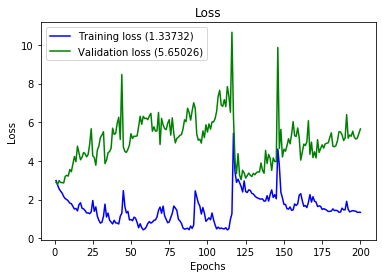

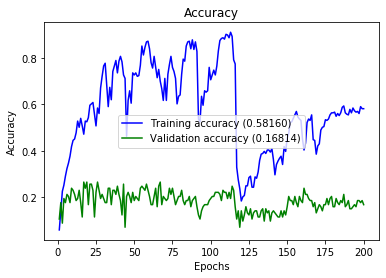

In [58]:
plot_history(hist)